# COSMO dataset first look

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

In [5]:
from src import data

We will start with loading the SPSS `.sav` file. 

In [6]:
# The conversion to `pd.Categorical` fails spectacularly, so we will do without it.
df = pd.read_spss(f"{data.data_root}/external/COSMO/INSERM.sav", convert_categoricals=False) 

In [7]:
import IPython

These are all the columns of the dataset.

In [74]:
print(IPython.utils.text.columnize(list(df.columns),displaywidth=99))

TIME                    COPING_ROUTINE        POL_DEMO              TRUST_PRINT_NEWS    
p_0001                  COPING_TALKING        POL_DISASTER          TRUST_PRIVATE_RADIO 
p_0002                  CORONA_PARTY          POL_DISCRIM           TRUST_PRIVATE_TV    
c_0001                  duration              POL_EVENTS            TRUST_RKI           
Condition_ACCESS        EDUCATION             POL_FITTRACK          TRUST_SCIENCE       
Condition_APP           EFFICACY              POL_FREEDOM           TRUST_SEARCH        
Condition_DCE           EP_AVOID              POL_HARVEST           TRUST_SOC_MEDIA     
Condition_DL            EP_CLOSE_CONTACT      POL_HOME              TRUST_STATE_HEALTH  
Condition_Mask          EP_COVERING           POL_IMMUN             TRUST_STATE_RADIO   
Condition_School        EP_CROWD              POL_INTERNET          TRUST_STATE_TV      
Condition_VAX           EP_EATING             POL_LIVING            TRUST_WHO           
CONDITION_W3         

In [9]:
df.head()

,TIME,p_0001,p_0002,c_0001,Condition_ACCESS,Condition_APP,Condition_DCE,Condition_DL,Condition_Mask,Condition_School,...,USE2_HANDWASH20,USE2_HOME,USE2_MASK,USE2_NEC_WAYS,USE2_SANITIZER,USE2_SPACE150,USE2_SQUAR_WITH,USE2_SQUAR_WITHOUT,USE2_TOUCHING,USE2_TRIPS
0,1.0,6ff716f0fc5156f6d62dc5533387b6dc,4521992249565,,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,574102bda67a1bbbcd30e350993efea4,4583241328176,,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,a0c8a07b54ff5f4f10d9dc2b844a47cf,4474656669602,,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,f5413d0770e9b4591ba54491a9118ce9,5357428691517,,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,3ac9f49abe66bac08f57e87954d9c9d7,5052713745002,,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ok, that looks reasonable, let's load the metadata for reference on the particular columns.

In [10]:
metadata = pd.read_csv(f"{data.data_root}/external/COSMO/variablen_Welle_9_INSERM_translated.csv")

In [11]:
metadata.columns

Index(['Konstrukt', 'Construct (Translated)', 'Variablenname',
       'Quelle (Unipark / R)', 'Instruktion', 'Instructions (translated)',
       'Fragentext', 'Text of question (translated)', 'Antwortformat',
       'Format of answer (translate)', 'fehlende Werte (Angabe durch Proband)',
       'fehlende Werte (systemseitig)',
       'Rekodierung in R (s. Tabellenblatt "neu berechnet")', 'Anmerkungen',
       'Notes (translated)', 'Änderung über Wellen hinweg',
       'change between waves (translated)\n', 'Welle 1\n03./04.03.',
       'Welle 2\n10./11.03.', 'Welle 3\n17./18.03.', 'Welle 4\n24./25.03.',
       'Welle 5\n31.03./01.04.', 'Welle 6\n07./08.04.', 'Welle 7\n14./15.04.',
       'Welle 8\n21./22.04.', 'Welle 9\n28./29.04.', 'Welle 10', 'Welle 11',
       'Welle 12', 'Welle 13', 'Welle 14', 'Welle 15'],
      dtype='object')

Good, now to the variables of interest for the first round of modeling. We are looking to inform:

* $\phi$ perceived happiness (perceived quality of live) 
* $u$  accumulation of fatigue  or psychological stress 

The following Affect group of variables is about how the subject is affected by Covid19:

> Please select one answer per line. The novel coronavirus is for me ...

In [13]:
metadata[
    metadata['Variablenname'].str.contains('^AFF', regex=True)
][
    ['Variablenname', 'Text of question (translated)']
]

,Variablenname,Text of question (translated)
137,AFF_DISTANCE,Nah - Far
138,AFF_SPREAD,Slowly spreading - Fast spreading
139,AFF_THINK,Something I keep thinking - something I almost...
140,AFF_FEAR,Frightening - Not scary
141,AFF_HYPE,Medial inflated - media attention too little
142,AFF_WORRY,Worrying - not worrying
143,AFF_HELPLESSNESS,Something where I feel helpless - something to...
626,AFF_NOVELITY,New old
627,AFF_SCIENCE,Totally unexplored - Very well researched


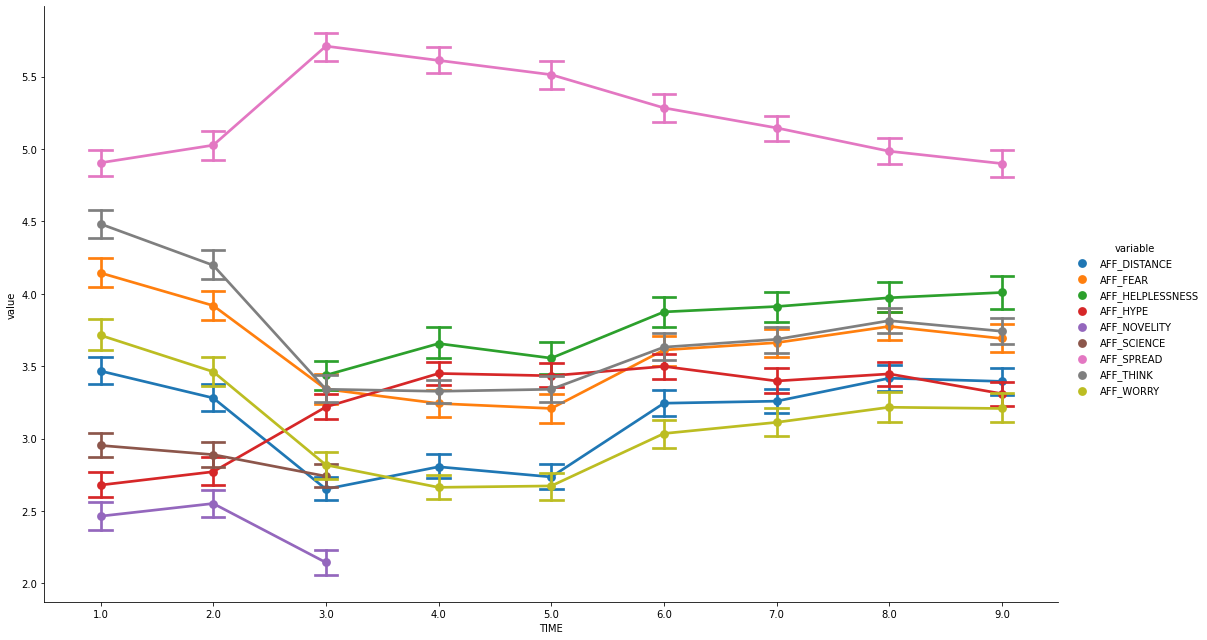

In [14]:
sns.catplot(
    data=df.filter(regex='TIME|^AFF',axis=1).melt('TIME', var_name='variable', value_name='value'),
    x='TIME', 
    y='value',
    hue='variable',
    kind='point',
    capsize=0.2,
    height=9,
    aspect=15/9
)

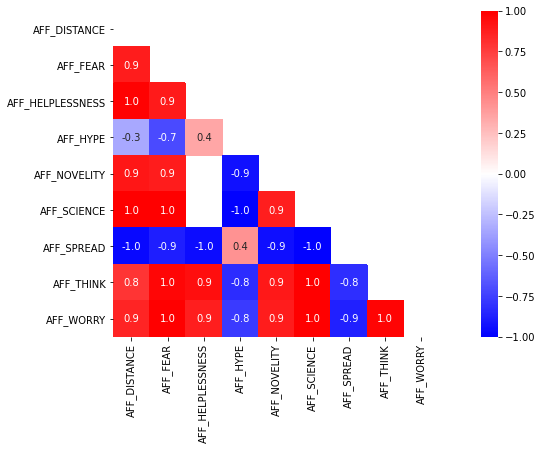

In [63]:
corr = df.filter(regex='TIME|^AFF',axis=1).groupby('TIME').mean().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=True,
    fmt=".1f",
    mask=mask,
    square=True
)

Now, these variables seem to be strongly correlated (with the interesting exception of `AFF_HYPE`). In terms of mapping to our variables, I'd say, that `AFF_FEAR`, `AFF_HELPLESSNESS`, and `AFF_WORRY`, could negatively impact happiness $\phi$. 

Let's look at the mental health group next. Here unfortunatelly we don't have many data points, and moreover the mean values don't change much... Life satisfaction seems to be closest to relevant measure, but there is not enough variability in the data.

In [15]:
metadata[
    metadata['Variablenname'].str.contains('LIFE_SAT|^PSY', regex=True)
][
    ['Variablenname', 'Text of question (translated)']
]

,Variablenname,Text of question (translated)
16,LIFE_SAT,How satisfied are you - all in all - with your...
17,PSY_1,"I felt nervous, anxious or tense."
18,PSY_2,I felt dejected / depressed.
19,PSY_3,I felt lonely.
20,PSY_4,I thought full of hope about the future.
21,PSY_5,Thoughts broke my experience in Corona pandemi...


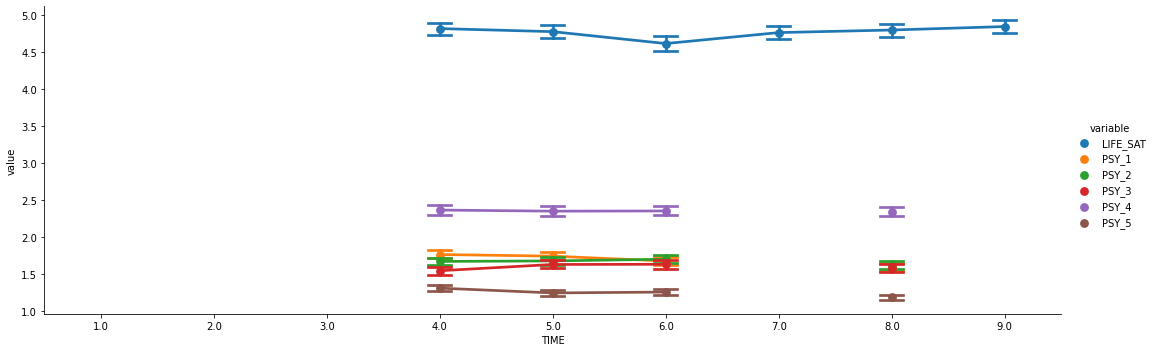

In [16]:
sns.catplot(
    data=df.filter(regex='TIME|LIFE_SAT|^PSY_',axis=1).melt('TIME', var_name='variable', value_name='value'),
    x='TIME', 
    y='value',
    hue='variable',
    kind='point',
    capsize=0.2,
    height=5,
    aspect=15/5
)

Same is true for next potential set of candidate variables, the resilience group.

In [17]:
metadata[
    metadata['Variablenname'].str.contains('TIME|^RESCOR_|^RES_', regex=True)
][
    ['Variablenname', 'Text of question (translated)']
]

,Variablenname,Text of question (translated)
522,RES_1,I tend to recover quickly after tough times.
523,RES_2,I find it difficult to get through stressful s...
524,RES_3,I do not need much time to recover from a stre...
525,RES_4,I find it difficult to return to normal if som...
526,RES_5,I usually stand difficult times without major ...
527,RES_6,I need tend to be long to get over setbacks in...
528,RESCOR_1,I find the necessary for me ways to keep going.
529,RESCOR_2,I know that I will not let me down.
530,RESCOR_3,I learn important and useful lessons for my life.
531,RESCOR_4,LEARN I ways to better deal with it next time.


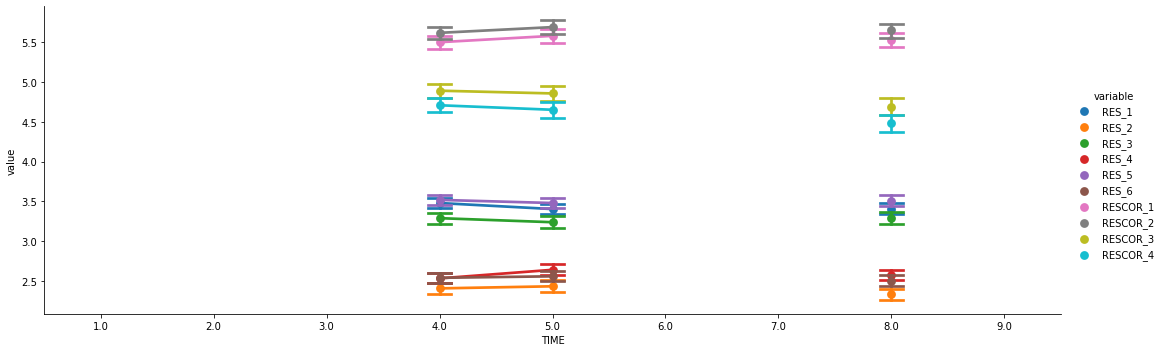

In [18]:
sns.catplot(
    data=df.filter(regex='TIME|^RESCOR_|^RES_',axis=1).melt('TIME', var_name='variable', value_name='value'),
    x='TIME', 
    y='value',
    hue='variable',
    kind='point',
    capsize=0.2,
    height=5,
    aspect=15/5
)

And finally the variables related to policies. These reflect indirectly the perceived risk induced by the pandemic, and again, could influence $\phi$.

In [19]:
metadata[
    metadata['Variablenname'].str.contains('^POL_', regex=True)
][
    ['Variablenname', 'Text of question (translated)']
]

,Variablenname,Text of question (translated)
212,POL_FREEDOM,The government should restrict personal libert...
213,POL_LIVING,The government should restrict the personal ri...
214,POL_INTERNET,The government should restrict access to the I...
215,POL_SCHOOL,Precaution should be community facilities such...
216,POL_NONE,I think the measures that are being taken grea...
217,POL_HOME,"It should be only allowed for work, health or ..."
218,POL_DISASTER,Throughout Germany should be declared a nation...
219,POL_PUNISH,Violations of curfew and Assembly bans should ...
220,POL_PRICING,Supermarkets should charge higher prices for p...
221,POL_MASK,From now on anyone who moves in public areas s...


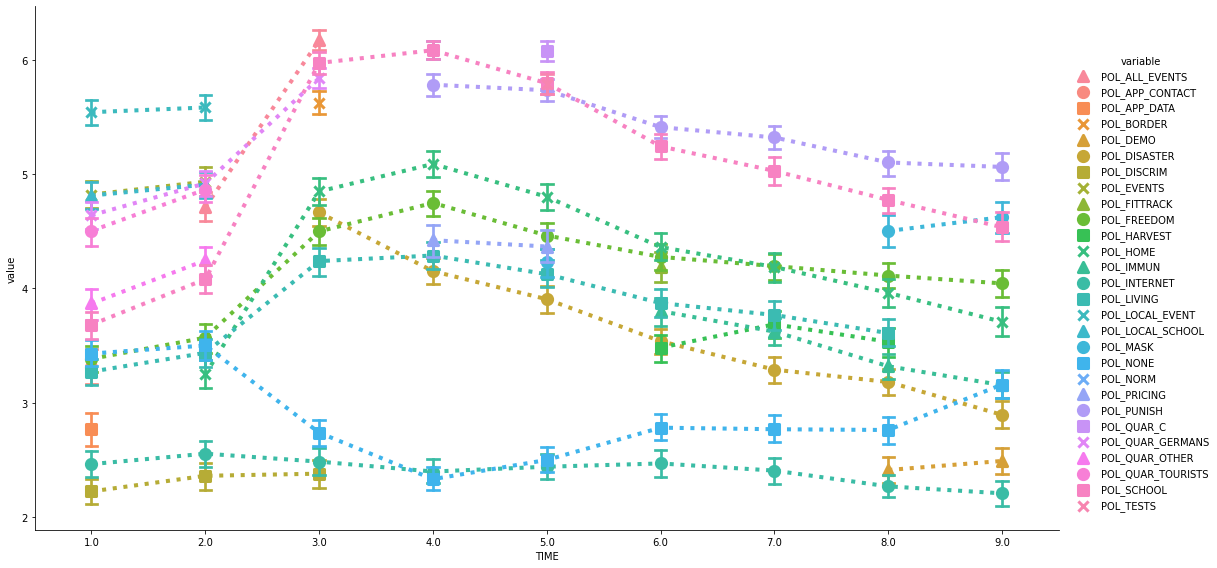

In [20]:
sns.catplot(
    data=df.filter(regex='TIME|^POL_',axis=1).melt('TIME', var_name='variable', value_name='value'),
    x='TIME', 
    y='value',
    hue='variable',
    kind='point',
    markers=["^", "o", "s", "x"]*14, 
    linestyles=[":"]*56,
    capsize=0.1,
    height=8,
    aspect=15/8,
    scale=1.5
)

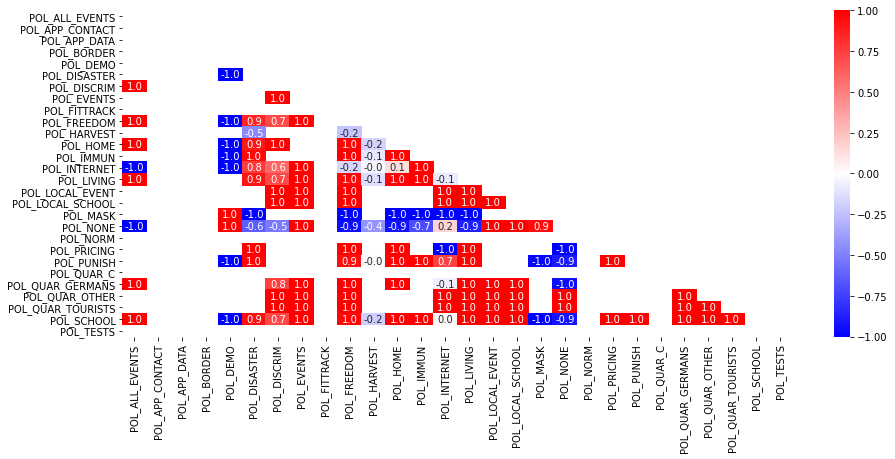

In [61]:
corr = df.filter(regex='TIME|^POL_',axis=1).groupby('TIME').mean().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=True,
    fmt=".1f",
    mask=mask
)

Here again are the variables highly correlated among each other and to the Affect group. Reasonable representants here might be `POL_NONE` (policies are exaggarated), and `POL_HOME` (everybody should stay home). The latter might be invariant to current policies which are in place.

Additionally, both the Affect and the Policies groups correlate together, suggesting that the choice of particular variable (or several) should not impact the sampling.

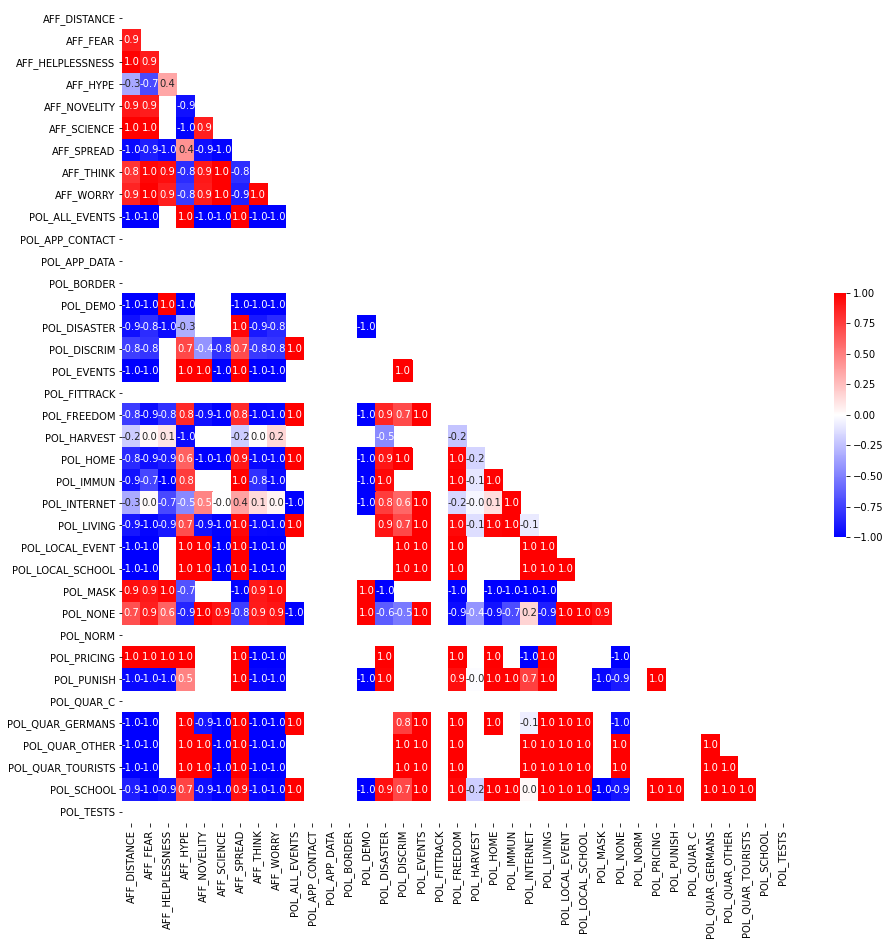

In [71]:
fig, ax = plt.subplots(figsize=(15,15))


corr = df.filter(regex='TIME|^POL_|^AFF_',axis=1).groupby('TIME').mean().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=True,
    fmt=".1f",
    mask=mask,
    ax=ax,
    cbar_kws={
        'shrink':0.3,
    }
)

A sidenote: the confidence intervals in the plots above are obtained by bootstrapping (95%), there is a quite a lot of variability in the data as shown in the example below where standard deviation is plotted instead.

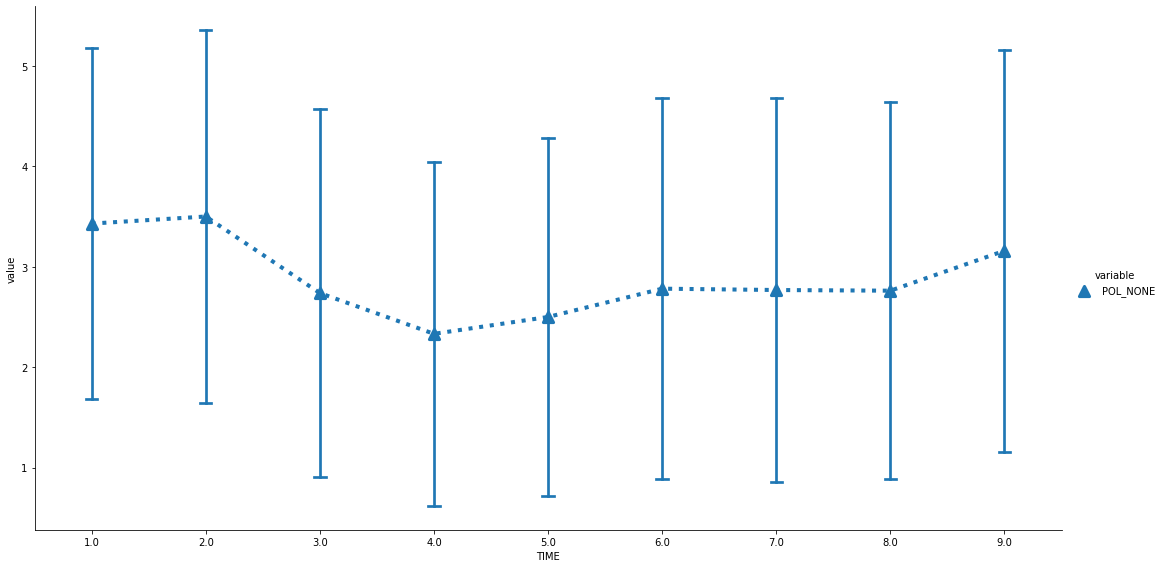

In [23]:
sns.catplot(
    data=df.filter(regex='TIME|POL_NONE',axis=1).melt('TIME', var_name='variable', value_name='value'),
    x='TIME', 
    y='value',
    hue='variable',
    kind='point',
    markers=["^", "o", "s", "x"]*14, 
    linestyles=[":"]*56,
    capsize=0.1,
    ci='sd',
    height=8,
    aspect=15/8,
    scale=1.5
)